# Voltage Anomaly Detection Analysis

IQR and Z-score based detection


In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (15, 8)

In [143]:
# from google.colab import files
# uploaded = files.upload()
df = pd.read_csv('substation_data_Ch.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
df.head()
# df.isna().sum()
# df.describe()

Dataset shape: (35136, 7)

Columns: ['timestamp', 'demand_kw', 'voltage_a', 'voltage_b', 'voltage_c', 'temperature_celsius', 'humidity_percent']


,timestamp,demand_kw,voltage_a,voltage_b,voltage_c,temperature_celsius,humidity_percent
0,2008-01-01 0:00:00,1.568400,241.158188,240.686236,240.496311,5.5,94.0
1,2008-01-01 0:15:00,1.562400,240.252448,240.833280,240.283343,5.5,94.0
2,2008-01-01 0:30:00,1.679867,242.296127,241.743477,242.627606,5.5,94.0
3,2008-01-01 0:45:00,1.577067,243.643363,242.619517,242.787405,5.5,94.0
4,2008-01-01 1:00:00,1.632267,240.375298,240.942674,241.069061,5.4,94.0


### Data Exploration and Preprocessing

In [144]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp')

# voltage columns
voltage_cols = ['voltage_a', 'voltage_b', 'voltage_c']

print("Voltage Data Summary:")
print("=" * 50)
print(df[voltage_cols].describe())

print("\nMissing Values:")
print("-" * 20)
for col in voltage_cols:
    missing_pct = (df[col].isnull().sum() / len(df)) * 100
    print(f"{col}: {missing_pct:.2f}%")

Voltage Data Summary:
          voltage_a     voltage_b     voltage_c
count  35131.000000  35131.000000  35131.000000
mean     240.625324    240.627011    240.625829
std        2.786680      2.788550      2.790049
min      225.840842    225.408287    225.699465
25%      238.886529    238.897341    238.875066
50%      240.623078    240.628256    240.627166
75%      242.468653    242.451018    242.465445
max      250.111123    249.530256    249.838380

Missing Values:
--------------------
voltage_a: 0.01%
voltage_b: 0.01%
voltage_c: 0.01%


In [145]:

print("Handling missing values...")
df_copy = df.set_index('timestamp') 
for col in voltage_cols:
    df_copy[col] = df_copy[col].interpolate(method='time').bfill().ffill()

df = df_copy.reset_index()

print("Missing values after treatment:")
print(df[voltage_cols].isnull().sum())

print("\nVoltage Statistics After Cleaning:")
print("=" * 40)
print(df[voltage_cols].describe())

Handling missing values...
Missing values after treatment:
voltage_a    0
voltage_b    0
voltage_c    0
dtype: int64

Voltage Statistics After Cleaning:
          voltage_a     voltage_b     voltage_c
count  35136.000000  35136.000000  35136.000000
mean     240.625205    240.626932    240.625716
std        2.786572      2.788413      2.789935
min      225.840842    225.408287    225.699465
25%      238.886417    238.897102    238.874836
50%      240.623038    240.628224    240.627404
75%      242.468458    242.450987    242.464972
max      250.111123    249.530256    249.838380


### Define Anomaly Criteria

Assuming Voltage is anomaly when:

1. **Statistical Outliers**: Values beyond 3 standard deviations or outside IQR bounds
2. **IQR Method**: Values outside Q1 - 1.5*IQR or Q3 + 1.5*IQR
3. **Z-Score Method**: Values with |z-score| > 3 (3 standard deviations from mean)
4. **Voltage Range Violations**: Values outside acceptable operating range

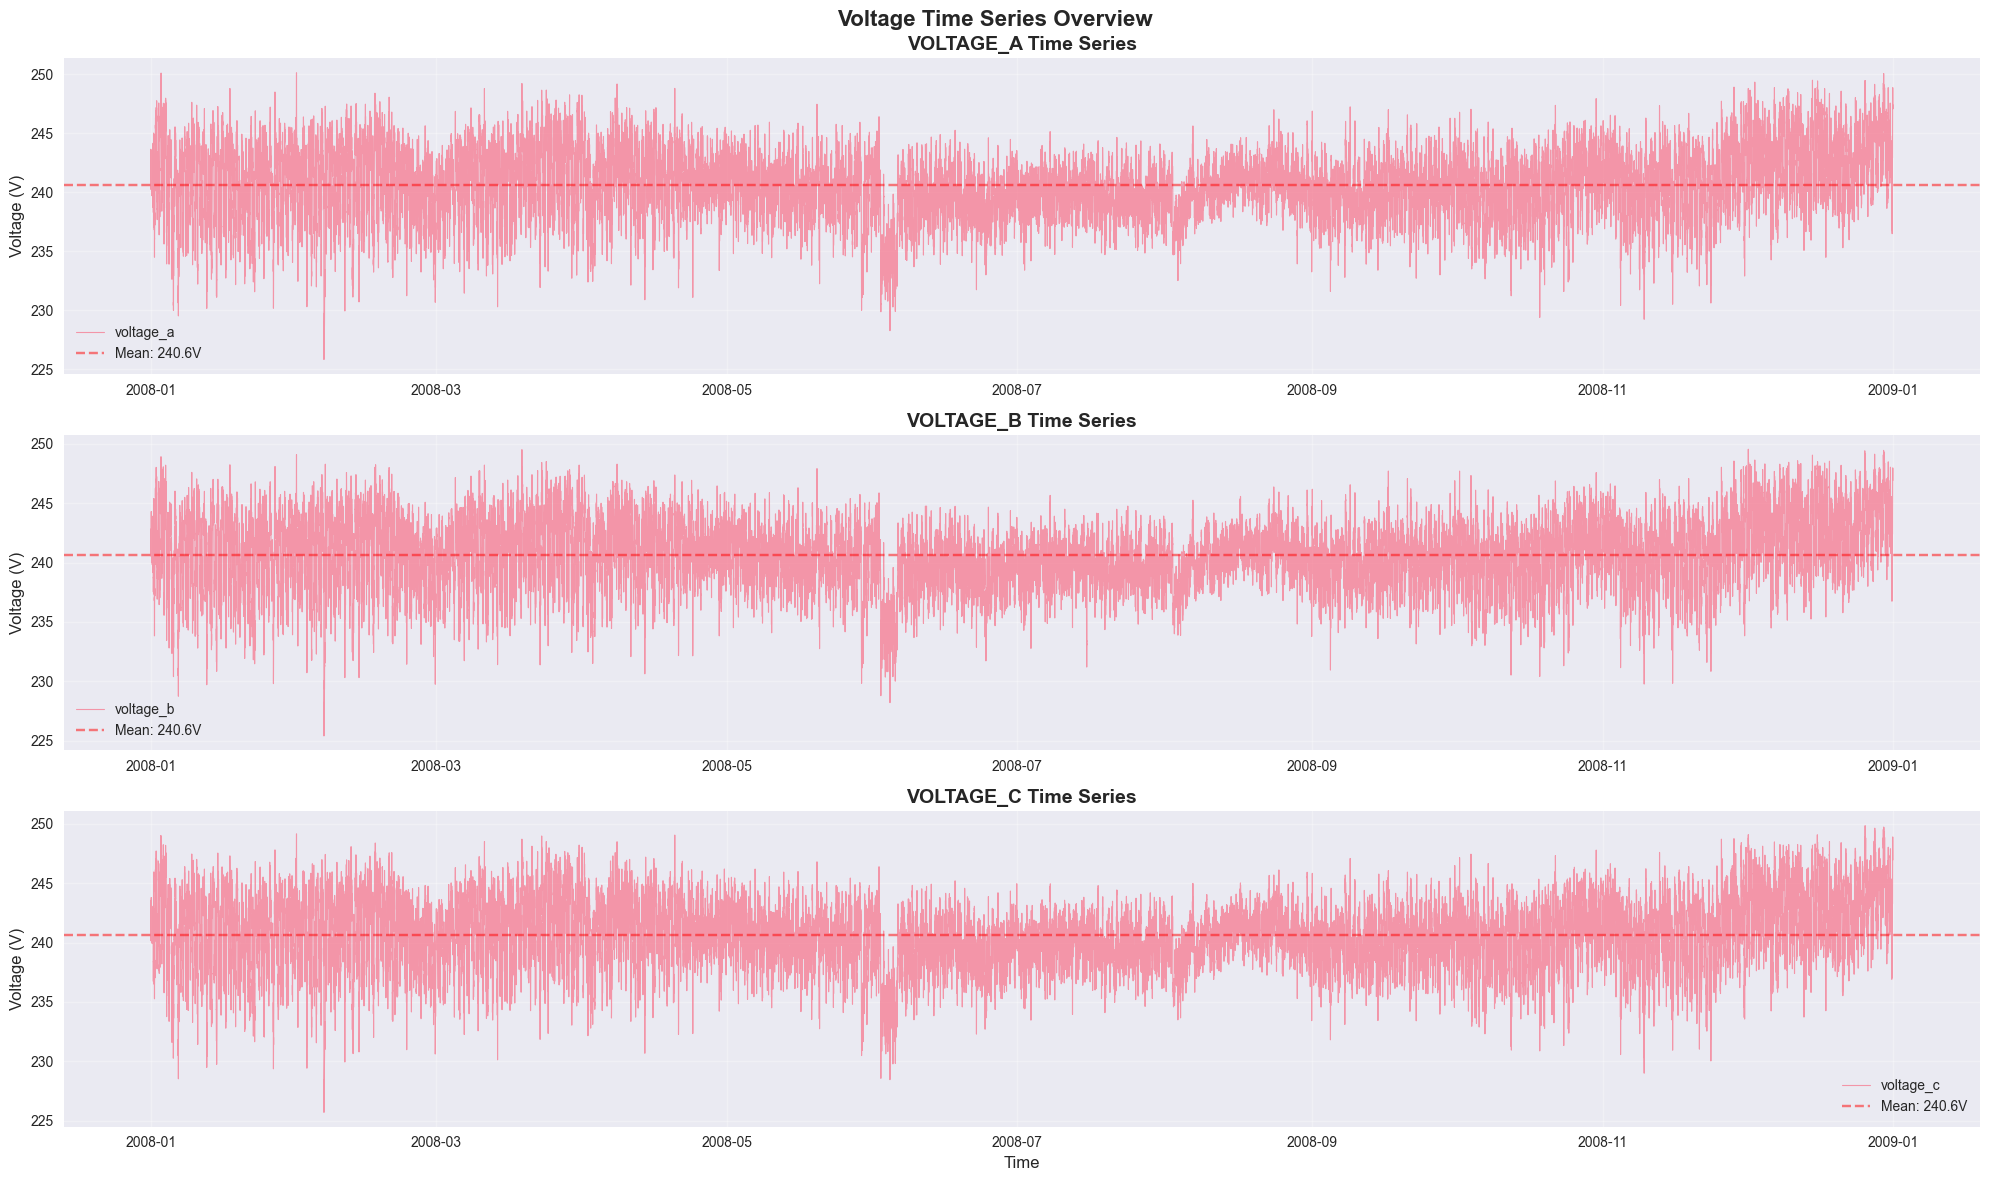

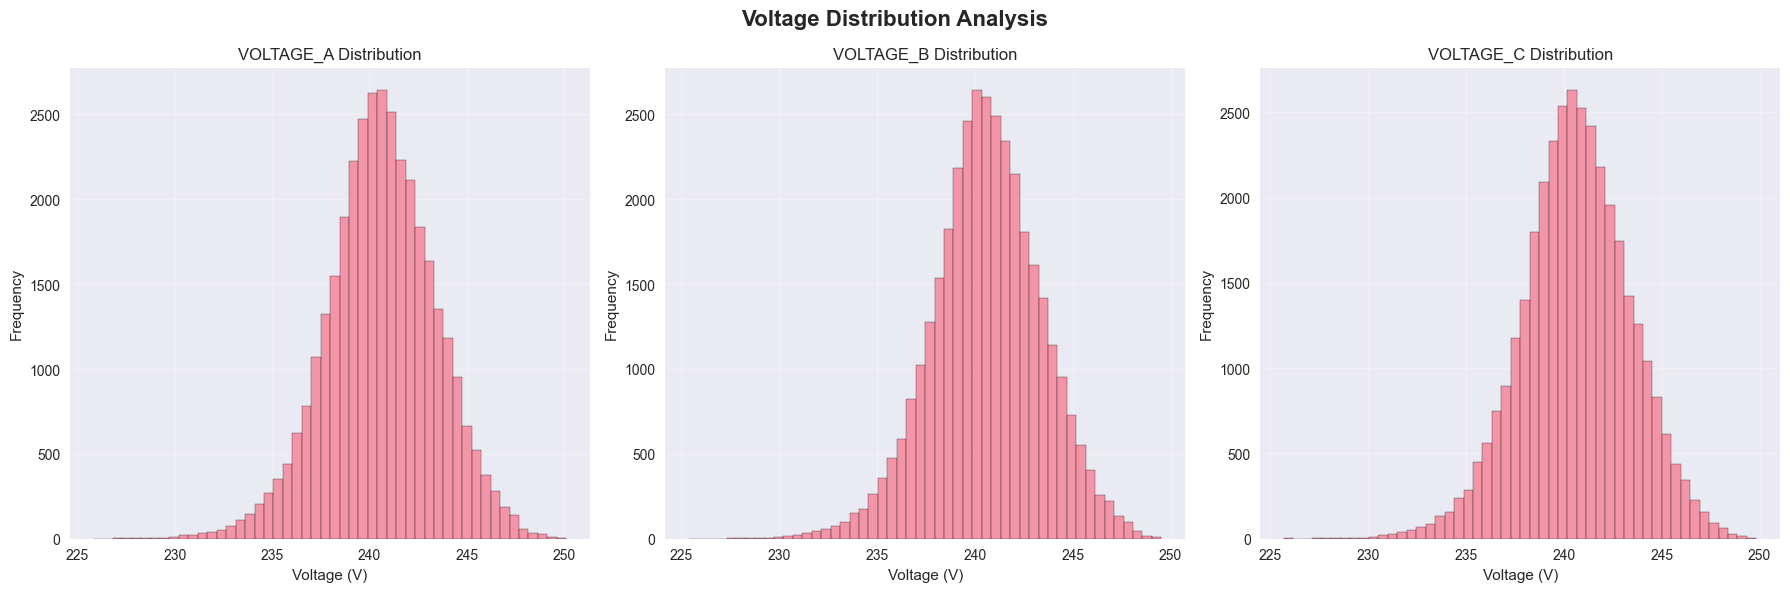

In [146]:

fig, axes = plt.subplots(3, 1, figsize=(20, 12))

for i, col in enumerate(voltage_cols):
    axes[i].plot(df['timestamp'], df[col], label=col, alpha=0.7, linewidth=0.8)
    axes[i].set_title(f'{col.upper()} Time Series', fontsize=14, fontweight='bold')
    axes[i].set_ylabel('Voltage (V)', fontsize=12)
    axes[i].grid(True, alpha=0.3)
    axes[i].legend()
    
    mean_val = df[col].mean()
    axes[i].axhline(y=mean_val, color='red', linestyle='--', alpha=0.5, label=f'Mean: {mean_val:.1f}V')
    axes[i].legend()

plt.xlabel('Time', fontsize=12)
plt.suptitle('Voltage Time Series Overview', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for i, col in enumerate(voltage_cols):
    axes[i].hist(df[col], bins=50, alpha=0.7, edgecolor='black')
    axes[i].set_title(f'{col.upper()} Distribution')
    axes[i].set_xlabel('Voltage (V)')
    axes[i].set_ylabel('Frequency')
    axes[i].grid(True, alpha=0.3)

plt.suptitle('Voltage Distribution Analysis', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

###  Statistical Anomaly Detection

In [147]:
def detect_statistical_anomalies(data, method='iqr', threshold=1.5):
    if method == 'iqr':
        Q1 = data.quantile(0.25)
        Q3 = data.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        anomalies = (data < lower_bound) | (data > upper_bound)
        
    elif method == 'zscore':
        z_scores = np.abs(stats.zscore(data))
        anomalies = z_scores > threshold
        lower_bound = data.mean() - threshold * data.std()
        upper_bound = data.mean() + threshold * data.std()
    
    return anomalies, lower_bound, upper_bound

statistical_anomalies = pd.DataFrame(index=df.index)
bounds = {}

print("Statistical Anomaly Detection Results:")
print("-" * 50)

for col in voltage_cols:
    iqr_anomalies, iqr_lower, iqr_upper = detect_statistical_anomalies(df[col], method='iqr', threshold=1.5)
    statistical_anomalies[f'{col}_iqr'] = iqr_anomalies
    
    zscore_anomalies, z_lower, z_upper = detect_statistical_anomalies(df[col], method='zscore', threshold=3)
    statistical_anomalies[f'{col}_zscore'] = zscore_anomalies
    
    bounds[col] = {
        'iqr_lower': iqr_lower, 'iqr_upper': iqr_upper,
        'z_lower': z_lower, 'z_upper': z_upper
    }
    
    print(f"{col.upper()}:")
    print(f"  IQR Anomalies: {iqr_anomalies.sum()} ({iqr_anomalies.sum()/len(df)*100:.2f}%)")
    print(f"  Z-Score Anomalies: {zscore_anomalies.sum()} ({zscore_anomalies.sum()/len(df)*100:.2f}%)")
    print(f"  IQR Bounds: [{iqr_lower:.2f}, {iqr_upper:.2f}]")
    print(f"  Z-Score Bounds: [{z_lower:.2f}, {z_upper:.2f}]")
    print()

Statistical Anomaly Detection Results:
--------------------------------------------------
VOLTAGE_A:
  IQR Anomalies: 463 (1.32%)
  Z-Score Anomalies: 166 (0.47%)
  IQR Bounds: [233.51, 247.84]
  Z-Score Bounds: [232.27, 248.98]

VOLTAGE_B:
  IQR Anomalies: 497 (1.41%)
  Z-Score Anomalies: 163 (0.46%)
  IQR Bounds: [233.57, 247.78]
  Z-Score Bounds: [232.26, 248.99]

VOLTAGE_C:
  IQR Anomalies: 470 (1.34%)
  Z-Score Anomalies: 170 (0.48%)
  IQR Bounds: [233.49, 247.85]
  Z-Score Bounds: [232.26, 249.00]



### Statistical Anomaly Consolidation

In [148]:
anomaly_summary = pd.DataFrame(index=df.index)
anomaly_summary['timestamp'] = df['timestamp']

for col in voltage_cols:
    anomaly_summary[col] = df[col]

for col in voltage_cols:
    anomaly_summary[f'{col}_iqr_anomaly'] = statistical_anomalies[f'{col}_iqr']
    anomaly_summary[f'{col}_zscore_anomaly'] = statistical_anomalies[f'{col}_zscore']

anomaly_columns = [col for col in anomaly_summary.columns if 'anomaly' in col]
anomaly_summary['any_anomaly'] = anomaly_summary[anomaly_columns].any(axis=1)

anomaly_summary['anomaly_count'] = anomaly_summary[anomaly_columns].sum(axis=1)

print("Statistical Anomaly Summary:")
print("=" * 40)
print(f"Total data points: {len(anomaly_summary)}")
print(f"Points flagged by any statistical method: {anomaly_summary['any_anomaly'].sum()} ({anomaly_summary['any_anomaly'].sum()/len(anomaly_summary)*100:.2f}%)")
print(f"\nAnomalies by statistical method:")
for col in anomaly_columns:
    count = anomaly_summary[col].sum()
    pct = count / len(anomaly_summary) * 100
    print(f"  {col}: {count} ({pct:.2f}%)")


Statistical Anomaly Summary:
Total data points: 35136
Points flagged by any statistical method: 635 (1.81%)

Anomalies by statistical method:
  voltage_a_iqr_anomaly: 463 (1.32%)
  voltage_a_zscore_anomaly: 166 (0.47%)
  voltage_b_iqr_anomaly: 497 (1.41%)
  voltage_b_zscore_anomaly: 163 (0.46%)
  voltage_c_iqr_anomaly: 470 (1.34%)
  voltage_c_zscore_anomaly: 170 (0.48%)


### Time Series with Statistical Anomalies

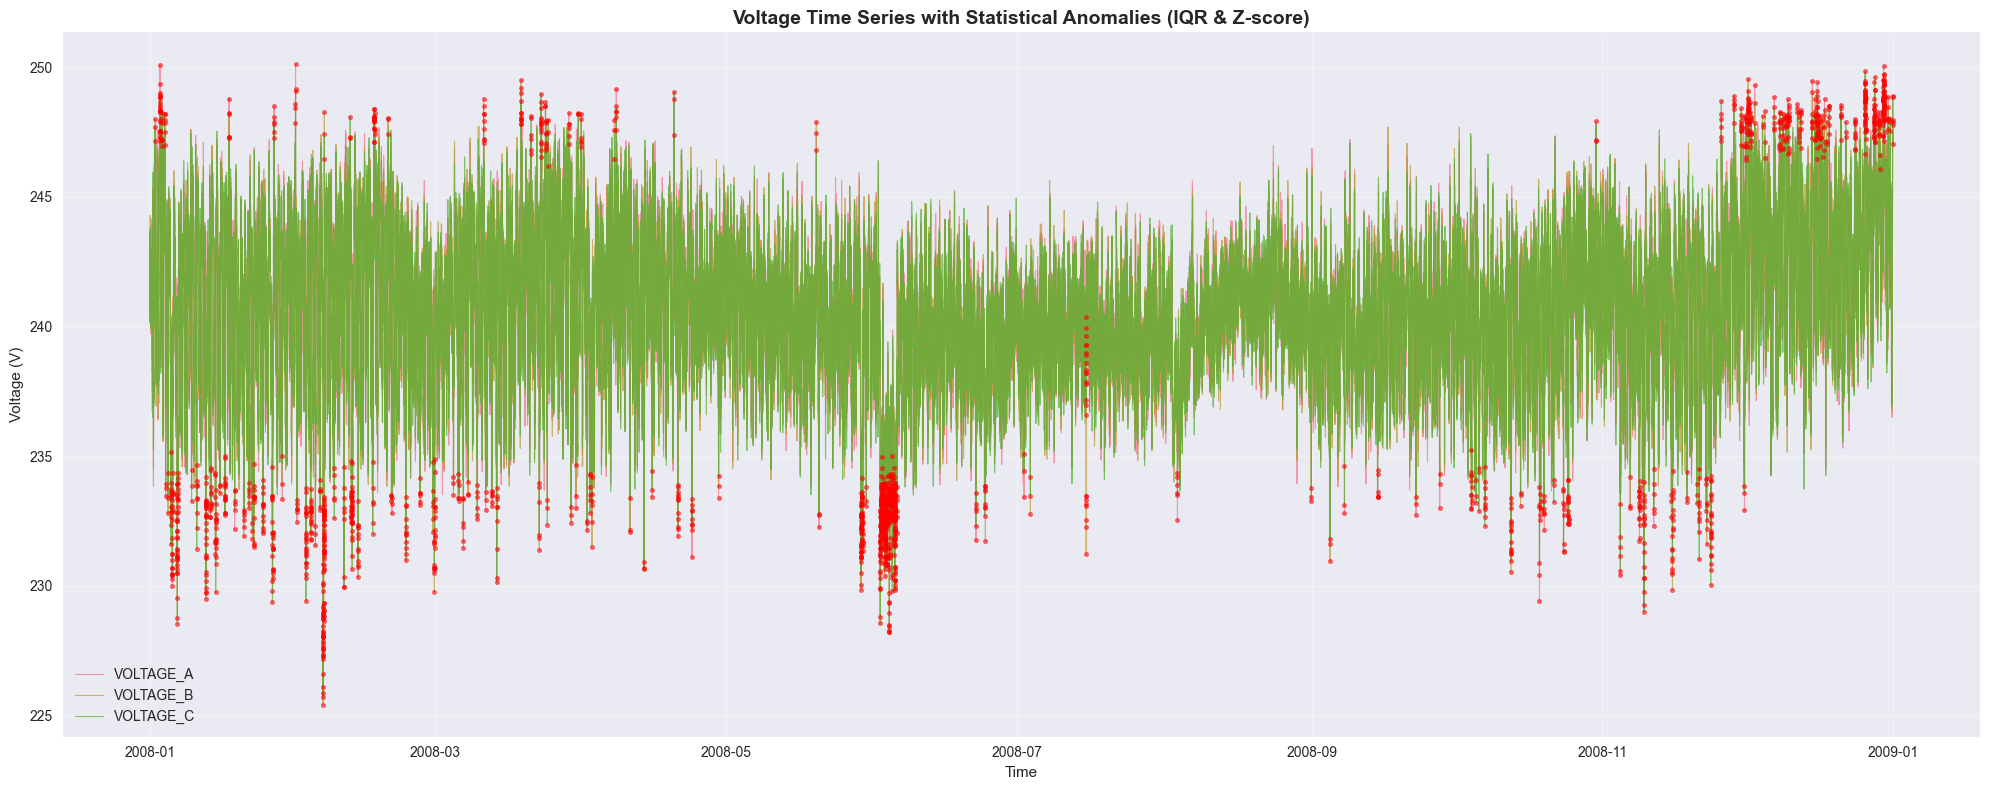

Statistical anomalies detected: 635 points


In [149]:
fig, axes = plt.subplots(1, 1, figsize=(20, 8))

#voltage phases
for col in voltage_cols:
    axes.plot(anomaly_summary['timestamp'], anomaly_summary[col], 
                label=col.upper(), alpha=0.7, linewidth=0.8)

# Highlight statistical anomalies
statistical_anomaly_points = anomaly_summary[anomaly_summary['any_anomaly']]
if len(statistical_anomaly_points) > 0:
    for col in voltage_cols:
        axes.scatter(statistical_anomaly_points['timestamp'], statistical_anomaly_points[col], 
                       c='red', s=10, alpha=0.6, zorder=5)

axes.set_title('Voltage Time Series with Statistical Anomalies (IQR & Z-score)', fontsize=14, fontweight='bold')
axes.set_ylabel('Voltage (V)')
axes.set_xlabel('Time')
axes.legend()
axes.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Statistical anomalies detected: {len(statistical_anomaly_points)} points")


### Detailed Anomaly Analysis

Total: 635 points

Top 10 Most Severe Anomalies:
----------------------------------------
Time: 2008-01-05 18:00:00
  Voltage A: 231.24V
  Voltage B: 230.45V
  Voltage C: 230.26V
Time: 2008-01-05 18:15:00
  Voltage A: 230.42V
  Voltage B: 230.69V
  Voltage C: 230.44V
Time: 2008-01-05 18:30:00
  Voltage A: 230.70V
  Voltage B: 231.22V
  Voltage C: 230.99V
Time: 2008-01-05 18:45:00
  Voltage A: 230.00V
  Voltage B: 230.40V
  Voltage C: 231.83V
Time: 2008-01-06 18:30:00
  Voltage A: 230.64V
  Voltage B: 230.48V
  Voltage C: 230.48V
Time: 2008-01-06 18:45:00
  Voltage A: 231.85V
  Voltage B: 231.24V
  Voltage C: 231.10V
Time: 2008-01-06 19:00:00
  Voltage A: 231.39V
  Voltage B: 231.10V
  Voltage C: 231.02V
Time: 2008-01-06 19:15:00
  Voltage A: 232.11V
  Voltage B: 231.13V
  Voltage C: 231.87V
Time: 2008-01-06 19:30:00
  Voltage A: 229.53V
  Voltage B: 228.75V
  Voltage C: 228.53V
Time: 2008-01-06 19:45:00
  Voltage A: 230.97V
  Voltage B: 231.42V
  Voltage C: 230.80V


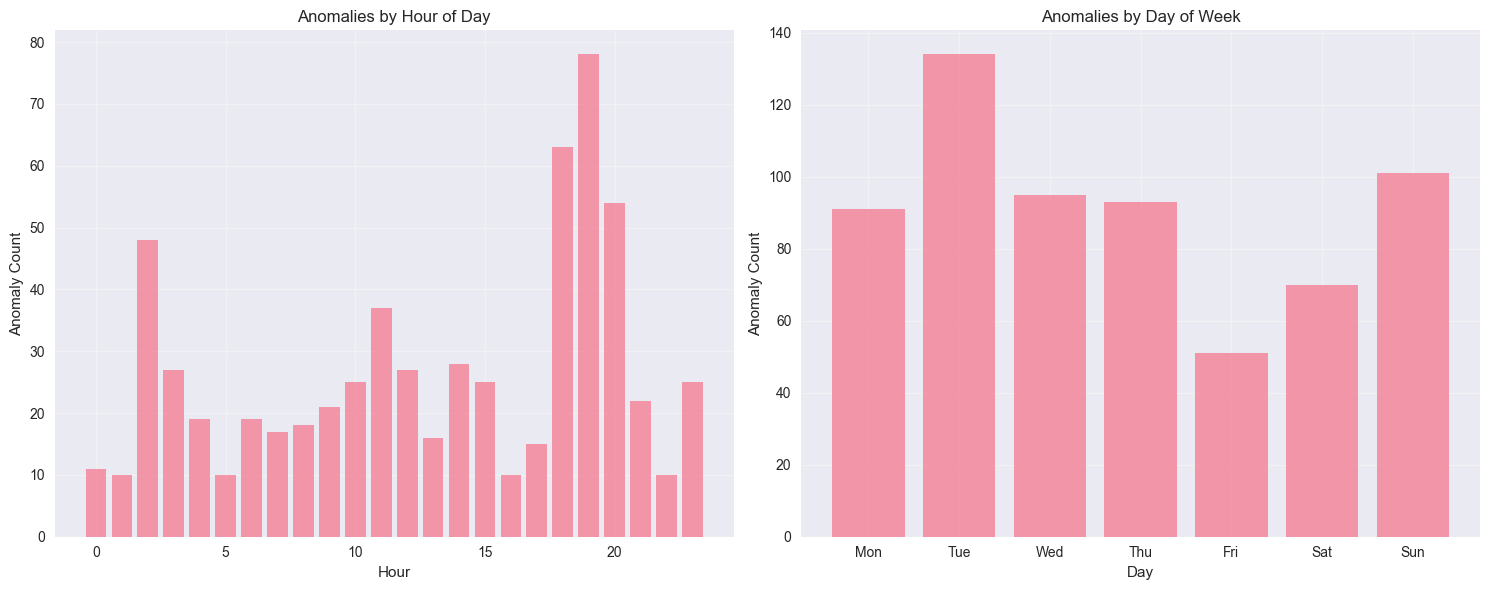


Temporal Patterns:
Peak anomaly hour: 19:00 (78 anomalies)
Peak anomaly day: Tue (134 anomalies)


In [150]:

high_confidence_anomalies = anomaly_summary[anomaly_summary['anomaly_count'] >= 1]

print(f"Total: {len(high_confidence_anomalies)} points")

if len(high_confidence_anomalies) > 0:
    print("\nTop 10 Most Severe Anomalies:")
    print("-" * 40)
    top_anomalies = high_confidence_anomalies.nlargest(10, 'anomaly_count')
    
    for idx, row in top_anomalies.iterrows():
        print(f"Time: {row['timestamp']}")
        print(f"  Voltage A: {row['voltage_a']:.2f}V")
        print(f"  Voltage B: {row['voltage_b']:.2f}V") 
        print(f"  Voltage C: {row['voltage_c']:.2f}V")
        # print(f"  Methods flagged: {int(row['anomaly_count'])}")
        # print()

anomaly_summary['hour'] = anomaly_summary['timestamp'].dt.hour
anomaly_summary['day_of_week'] = anomaly_summary['timestamp'].dt.dayofweek

hourly_anomalies = anomaly_summary.groupby('hour')['any_anomaly'].sum()
daily_anomalies = anomaly_summary.groupby('day_of_week')['any_anomaly'].sum()

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Hourly pattern
axes[0].bar(hourly_anomalies.index, hourly_anomalies.values, alpha=0.7)
axes[0].set_title('Anomalies by Hour of Day')
axes[0].set_xlabel('Hour')
axes[0].set_ylabel('Anomaly Count')
axes[0].grid(True, alpha=0.3)

# Daily pattern
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[1].bar(range(7), daily_anomalies.values, alpha=0.7)
axes[1].set_title('Anomalies by Day of Week')
axes[1].set_xlabel('Day')
axes[1].set_ylabel('Anomaly Count')
axes[1].set_xticks(range(7))
axes[1].set_xticklabels(day_names)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nTemporal Patterns:")
print(f"Peak anomaly hour: {hourly_anomalies.idxmax()}:00 ({hourly_anomalies.max()} anomalies)")
print(f"Peak anomaly day: {day_names[daily_anomalies.idxmax()]} ({daily_anomalies.max()} anomalies)")

### Summary

In [151]:
total_points = len(anomaly_summary)
total_anomalies = anomaly_summary['any_anomaly'].sum()
high_confidence = len(high_confidence_anomalies)

print("VOLTAGE ANOMALY DETECTION - FINAL SUMMARY")
print("=" * 55)
print(f"Dataset: {total_points:,} data points analyzed")
print(f"Time period: {anomaly_summary['timestamp'].min()} to {anomaly_summary['timestamp'].max()}")
print(f"\nANOMALY DETECTION RESULTS:")
print(f"  Total anomalies detected: {total_anomalies:,} ({total_anomalies/total_points*100:.2f}%)")
print(f"  High-confidence anomalies: {high_confidence:,} ({high_confidence/total_points*100:.2f}%)")

print(f"\nMETHODOLOGY SUMMARY:")
print(f"  ✓ Statistical Methods: IQR and Z-score outlier detection")

print(f"\nANOMALY DEFINITIONS:")
print(f"  • Statistical Outliers: Values > outside IQR bounds")


VOLTAGE ANOMALY DETECTION - FINAL SUMMARY
Dataset: 35,136 data points analyzed
Time period: 2008-01-01 00:00:00 to 2008-12-31 23:45:00

ANOMALY DETECTION RESULTS:
  Total anomalies detected: 635 (1.81%)
  High-confidence anomalies: 635 (1.81%)

METHODOLOGY SUMMARY:
  ✓ Statistical Methods: IQR and Z-score outlier detection

ANOMALY DEFINITIONS:
  • Statistical Outliers: Values > outside IQR bounds
